<a href="https://colab.research.google.com/github/ayoubms8/Topiary/blob/main/Topiary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def load_data(file_path):

    try:
        df = pd.read_csv(file_path, encoding='utf-8', sep=',', engine='python', on_bad_lines='skip')
        if len(df.columns) > 1: return clean_df(df)
    except: pass


    try:
        df = pd.read_csv(file_path, encoding='latin-1', sep=',', engine='python', on_bad_lines='skip')
        if len(df.columns) > 1: return clean_df(df)
    except: pass


    try:
        df = pd.read_csv(file_path, encoding='latin-1', sep=';', engine='python', on_bad_lines='skip')
        if len(df.columns) > 1: return clean_df(df)
    except: pass

    raise ValueError("Could not parse CSV with any standard format.")

def clean_df(df):

    df.columns = df.columns.str.strip()


    if df.columns[0] == '' or 'Unnamed' in df.columns[0]:
        df = df.iloc[:, 1:]


    df = df.apply(pd.to_numeric, errors='coerce')
    return df
df = load_data("Data_Final.csv")
sulfur_cols = [c for c in df.columns if 'soufre' in c.lower() or '01' in c]
print(f"Found Sulfur Columns: {sulfur_cols}")
if len(sulfur_cols) < 2:
    print("WARNING: Still seeing combined columns. Retrying with fixed encoding...")

    df = pd.read_csv("Data_Final.csv", encoding='latin-1', sep=',')
    df.columns = df.columns.str.strip()
    sulfur_cols = [c for c in df.columns if 'soufre' in c.lower()]

df['Total_Sulfur'] = df[sulfur_cols].sum(axis=1)
inputs = ['Total_Sulfur', 'Adm GTA1', 'Adm GTA2', 'Adm GTA3']
outputs = ['P GTA1', 'P GTA2', 'P GTA3', 'P GTAA', 'P GTAB', 'Pession vap MP1', 'S TR1', 'S TR2', 'S TR3']
print("Columns in DF:", df.columns.tolist())
df_clean = df[inputs + outputs].dropna()
df_clean = df_clean[(df_clean > 5).any(axis=1)]

print(f"Clean Data Shape: {df_clean.shape}")

Found Sulfur Columns: ['Débit de soufre 01A', 'Débit de soufre 01B', 'Débit de soufre 01C', 'Débit de soufre 01X', 'Débit de soufre 01Y', 'Débit de soufre 01Z']
Columns in DF: ['Débit de soufre 01A', 'Débit de soufre 01B', 'Débit de soufre 01C', 'Débit de soufre 01X', 'Débit de soufre 01Y', 'Débit de soufre 01Z', 'Adm GTA1', 'Sout 1', 'P GTA1', 'Adm GTA2', 'Sout 2', 'P GTA2', 'Adm GTA3', 'Sout 3', 'P GTA3', 'CAP N', 'CAPS', 'P GTAA', 'P GTAB', 'Q MP CAP depuis NC', 'S TR1', 'S TR2', 'S TR3', 'Pession vap MP1', 'Pession vap MP2', 'Total_Sulfur']
Clean Data Shape: (18115, 13)


In [ ]:
from sklearn.model_selection import train_test_split
X = df_clean[inputs]
y = df_clean[outputs]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 14492
Testing samples: 3623


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=30, random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=50, random_state=42))
}

results = []

print("Training models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    score = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)

    results.append({
        "Model": name,
        "R2 Score (Accuracy)": round(score, 4),
        "MAE (Avg Error)": round(mae, 4)
    })
    print(f"Finished: {name}")

results_df = pd.DataFrame(results).sort_values(by="R2 Score (Accuracy)", ascending=False)
results_df

Training models...
Finished: Linear Regression
Finished: Decision Tree
Finished: Random Forest
Finished: Gradient Boosting


,Model,R2 Score (Accuracy),MAE (Avg Error)
2,Random Forest,0.8725,1.7205
1,Decision Tree,0.7573,2.7754
3,Gradient Boosting,0.6304,4.5837
0,Linear Regression,0.3069,7.0788


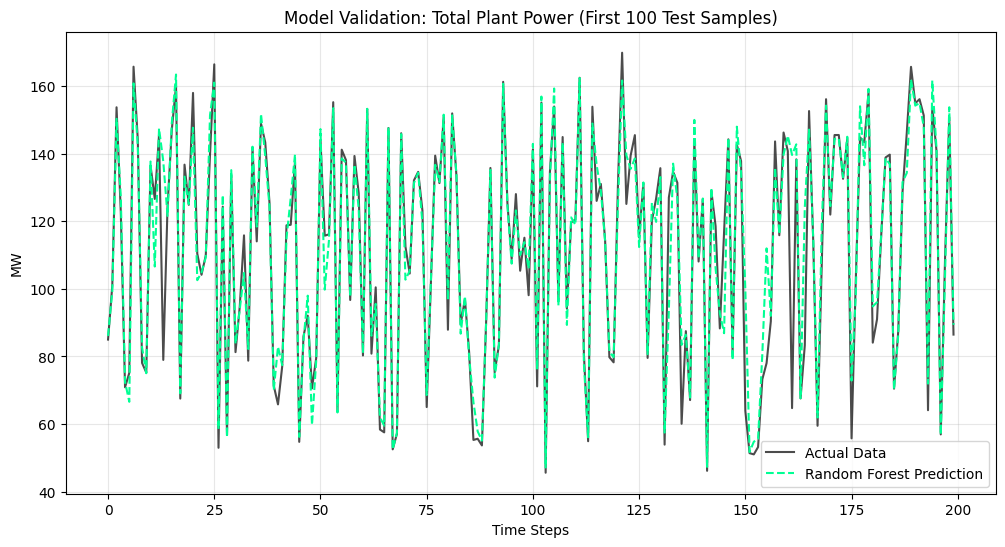

In [ ]:
# Visualize Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

test_preds = best_model.predict(X_test)
test_preds_df = pd.DataFrame(test_preds, columns=outputs)

# Compare Total Power
actual_power = y_test['P GTA1'] + y_test['P GTA2'] + y_test['P GTA3'] + y_test['P GTAA'] + y_test['P GTAB']
pred_power = test_preds_df['P GTA1'] + test_preds_df['P GTA2'] + test_preds_df['P GTA3'] + test_preds_df['P GTAA'] + test_preds_df['P GTAB']

actual_power = actual_power.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(actual_power[:200], label='Actual Data', color='black', alpha=0.7)
plt.plot(pred_power[:200], label=f'{best_model_name} Prediction', color='#00FF94', linestyle='--')
plt.title(f"Model Validation: Total Plant Power (First 100 Test Samples)")
plt.ylabel("MW")
plt.xlabel("Time Steps")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

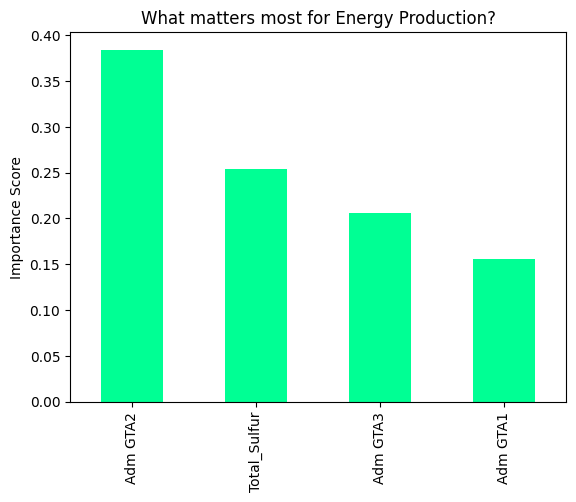

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_model.feature_importances_

feature_names = inputs
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(ax=ax, color='#00FF94')
ax.set_title("What matters most for Energy Production?")
ax.set_ylabel("Importance Score")
plt.show()

In [ ]:
import time
from scipy.optimize import minimize, differential_evolution
total_adm = df['Adm GTA1'] + df['Adm GTA2'] + df['Adm GTA3']
steam_ratio = (total_adm / df['Total_Sulfur']).median()
print(f"Calculated Steam Ratio: {steam_ratio:.2f} tons Steam / ton Sulfur")
def objective_function(admissions, sulfur_in):


    input_vector = [[sulfur_in, admissions[0], admissions[1], admissions[2]]]


    preds = best_model.predict(input_vector)[0]



    total_power = preds[0] + preds[1] + preds[2] + preds[3] + preds[4]

    return -total_power
def constraint_steam_balance(admissions, sulfur_in):

    available = sulfur_in * steam_ratio
    used = np.sum(admissions)
    return available - used

Calculated Steam Ratio: 4.01 tons Steam / ton Sulfur


In [ ]:

def run_slsqp(sulfur_in):
    max_steam = sulfur_in * steam_ratio
    cons = ({'type': 'ineq', 'fun': lambda x: max_steam - np.sum(x)})
    bnds = ((0, 220), (0, 220), (0, 220))
    x0 = [max_steam/3, max_steam/3, max_steam/3]

    start = time.time()
    res = minimize(lambda x: objective_function(x, sulfur_in), x0, method='SLSQP', bounds=bnds, constraints=cons)
    return -res.fun, time.time() - start

def run_cobyla(sulfur_in):
    max_steam = sulfur_in * steam_ratio

    cons = [
        {'type': 'ineq', 'fun': lambda x: max_steam - np.sum(x)},
        {'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'ineq', 'fun': lambda x: 220 - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]}, {'type': 'ineq', 'fun': lambda x: 220 - x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]}, {'type': 'ineq', 'fun': lambda x: 220 - x[2]}
    ]
    x0 = [max_steam/3, max_steam/3, max_steam/3]

    start = time.time()
    res = minimize(lambda x: objective_function(x, sulfur_in), x0, method='COBYLA', constraints=cons)
    return -res.fun, time.time() - start

def run_genetic(sulfur_in):
    max_steam = sulfur_in * steam_ratio
    bnds = [(0, 220), (0, 220), (0, 220)]


    def penalized_obj(x):
        if np.sum(x) > max_steam: return 99999
        return objective_function(x, sulfur_in)

    start = time.time()
    res = differential_evolution(penalized_obj, bounds=bnds, maxiter=20, popsize=10, polish=False)
    return -res.fun, time.time() - start

def run_random(sulfur_in, n_iter=50):
    max_steam = sulfur_in * steam_ratio
    best_pwr = 0
    start = time.time()

    for _ in range(n_iter):
        r = np.random.rand(3)
        r = r / np.sum(r) * max_steam
        r = np.clip(r, 0, 220)
        pwr = -objective_function(r, sulfur_in)
        if pwr > best_pwr: best_pwr = pwr

    return best_pwr, time.time() - start

In [ ]:
import numpy as np
import seaborn as sns

# Create 50 test scenarios
n_scenarios = 50
test_sulfur = np.random.uniform(50, 150, n_scenarios)
results_data = []

print(f"Running Benchmark on {n_scenarios} scenarios...")

for i, sulfur in enumerate(test_sulfur):
    if i % 10 == 0: print(f"Processing {i}/{n_scenarios}...")

    # Run all solvers on this specific scenario
    p1, t1 = run_slsqp(sulfur)
    results_data.append({"Solver": "SLSQP", "Power": p1, "Time": t1})

    p2, t2 = run_cobyla(sulfur)
    results_data.append({"Solver": "COBYLA", "Power": p2, "Time": t2})

    p3, t3 = run_genetic(sulfur)
    results_data.append({"Solver": "Genetic (DE)", "Power": p3, "Time": t3})

    p4, t4 = run_random(sulfur)
    results_data.append({"Solver": "Random Search", "Power": p4, "Time": t4})

df_results = pd.DataFrame(results_data)
print("Benchmark Complete.")

/tmp/ipython-input-3588221326.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Solver", y="Time", palette="viridis")
/tmp/ipython-input-3588221326.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x="Solver", y="Power", palette="magma")


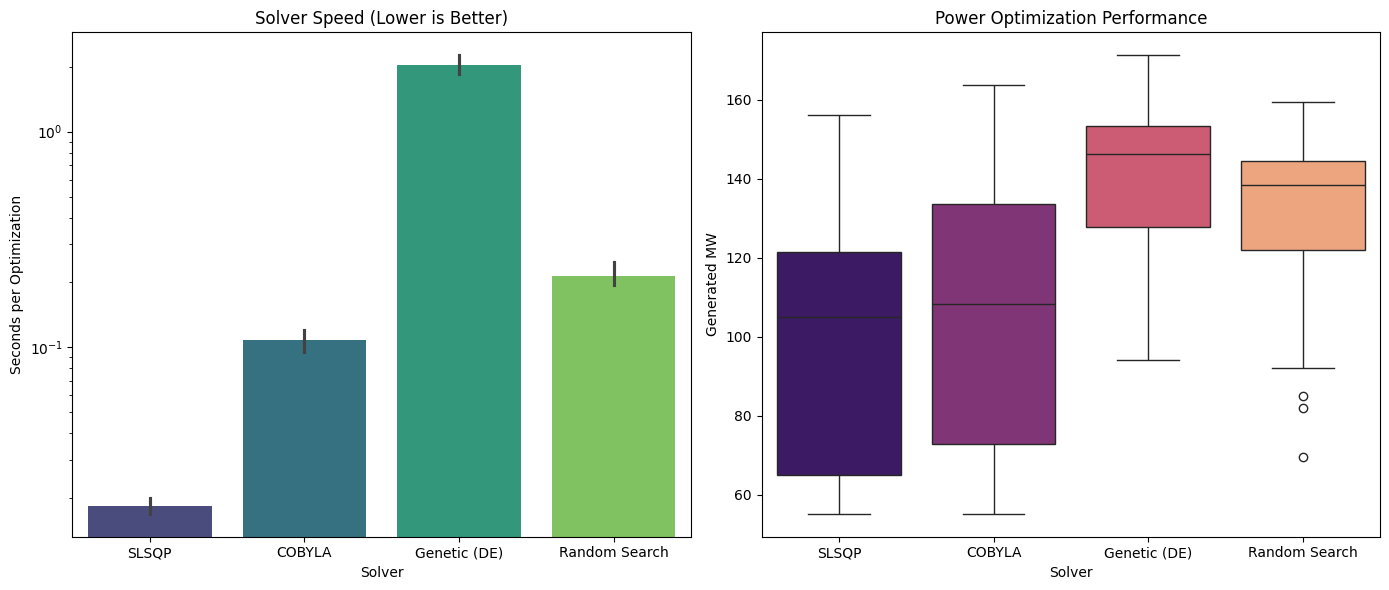

,Power,Time
Solver,,
Genetic (DE),141.913910,2.041232
Random Search,130.547685,0.215267
COBYLA,105.538581,0.108267
SLSQP,100.082839,0.018426


In [ ]:
plt.figure(figsize=(14, 6))

# Plot 1: Speed
plt.subplot(1, 2, 1)
sns.barplot(data=df_results, x="Solver", y="Time", palette="viridis")
plt.title("Solver Speed (Lower is Better)")
plt.ylabel("Seconds per Optimization")
plt.yscale("log") # Log scale because Genetic is usually very slow

# Plot 2: Performance Distribution
plt.subplot(1, 2, 2)
sns.boxplot(data=df_results, x="Solver", y="Power", palette="magma")
plt.title("Power Optimization Performance")
plt.ylabel("Generated MW")

plt.tight_layout()
plt.show()

# Leaderboard
leaderboard = df_results.groupby("Solver").mean().sort_values(by="Power", ascending=False)
display(leaderboard)

**We chose to go for random search because it seems to have similar range to Genetic DE which should be the most accurate while being considerably faster**